In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-05-15 20:26:59--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 172.253.63.139, 172.253.63.138, 172.253.63.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.63.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/viokk3nq7egi1874q6nem5fh0q80i3cf/1684182375000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=c6a079fe-a427-496a-940b-c855d02b3f56 [following]
--2023-05-15 20:27:00--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/viokk3nq7egi1874q6nem5fh0q80i3cf/1684182375000/04309230031174164349/*/1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-?e=download&uuid=c6a079fe-a427-496a-940b-c855d02b3f56
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 142.251.

In [4]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

In [5]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.101 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.5/107.7 GB disk)


In [9]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q Cython
!pip install -q cython_bbox
!pip install -q onemetric
!pip install "numpy<1.24"
!pip install loguru
!pip install lap

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [10]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [11]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [12]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [13]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [14]:
# settings
MODEL = "yolov8x.pt"

In [15]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 149MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [16]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 3 cars, 1 truck, 2790.4ms
Speed: 15.1ms preprocess, 2790.4ms inference, 52.0ms postprocess per image at shape (1, 3, 640, 640)


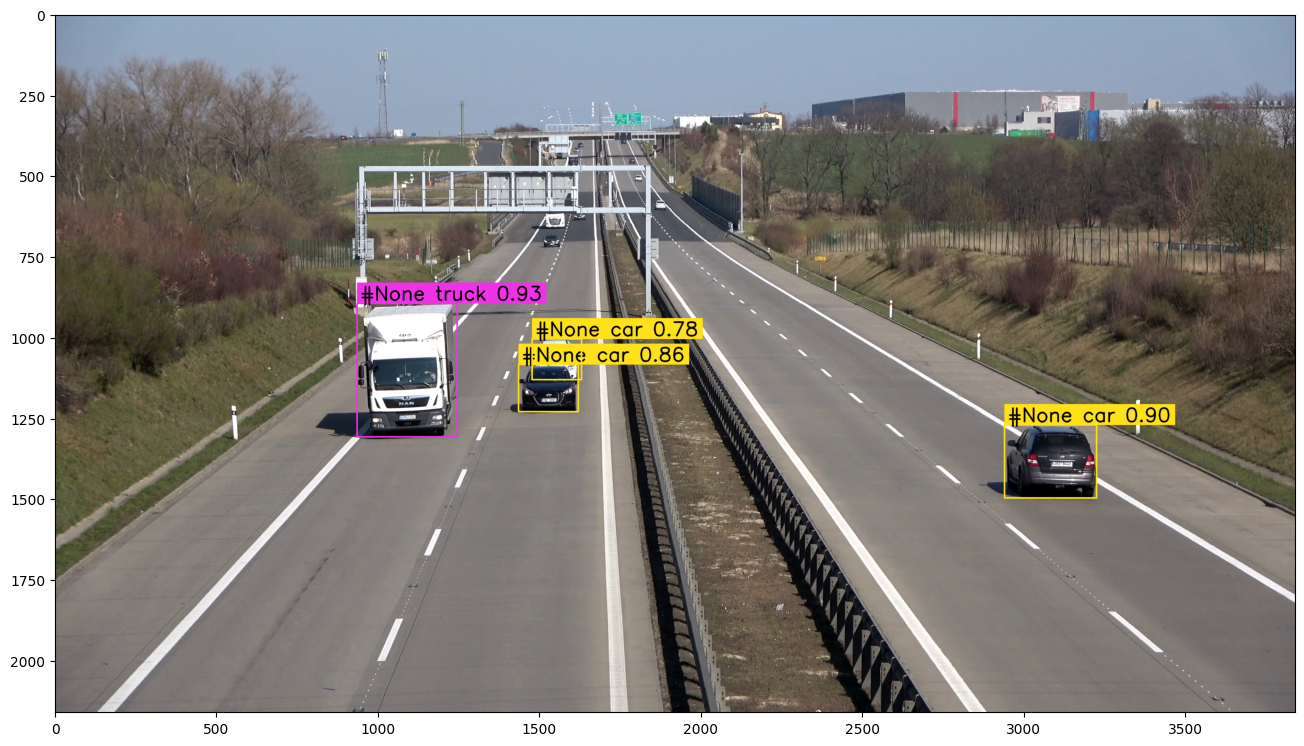

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [ ]:
video_info

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
from pprint import pprint

pprint(speeds)

NameError: ignored

In [ ]:
def calculate_car_center(bbox):
    x1, y1, x2, y2 = bbox
    return ((x1 + x2) // 2, (y1 + y2) // 2)

from tqdm.notebook import tqdm
import time
import math
import cv2

SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

prev_auto = None
curr_auto = None

previous_positions = {}

X1_CALCULATE_SPEED = (50, 500)
Y1_CALCULATE_SPEED = (3840-50, 500)

X2_CALCULATE_SPEED = (50, 800)
Y2_CALCULATE_SPEED = (3840-50, 800)

speeds = {}

compression_level = 20
# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        
        
        #for box, confidence, class_id, tracker_id in detections:
         #   print(f"{box} - {confidence} - {class_id} - {tracker_id}")
            
        
        
        # format custom labels        
        #labels = [
        #    f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f} {speeds[tracker_id]}km/h"
        #    for _, confidence, class_id, tracker_id
        #    in detections if tracker_id in speeds.keys()
        #]
        
        for bbox, _, _, tracker_id in detections:
            speed = 0
            curr_pos = calculate_car_center(bbox)
            if previous_positions.get(tracker_id, None) is not None and curr_pos[1] >= X1_CALCULATE_SPEED[1] and curr_pos[1] <= X2_CALCULATE_SPEED[1]:
                prev_pos = previous_positions.get(tracker_id, None)
                distance_traveled = math.sqrt((curr_pos[0] - prev_pos[0]) ** 2 + (curr_pos[1] - prev_pos[1]) ** 2)
                time_between_frames = 1 / video_info.fps
                speed = (distance_traveled ) / (time_between_frames)
                #print(f"#{tracker_id} speed : {speed} - coordinate: {curr_pos[1]}")
            
            if speeds.get(tracker_id, None) is None and speed != 0:
                speeds[tracker_id] = [speed]
            elif speeds.get(tracker_id, None) is not None and speed != 0:
                speeds[tracker_id].append(speed)
            previous_positions[tracker_id] = calculate_car_center(bbox)
        
        
        
        labels = []
        
        for _, confidence, class_id, tracker_id in detections:
            if tracker_id in speeds.keys():
                labels.append(f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f} {np.mean(speeds[tracker_id]):0.1f}km/h")
            else:
                labels.append(f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f} NA km/h")
        
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        cv2.line(frame, X1_CALCULATE_SPEED, Y1_CALCULATE_SPEED, (255, 0, 0), thickness=2,)
        cv2.line(frame, X2_CALCULATE_SPEED, Y2_CALCULATE_SPEED, (255, 0, 0), thickness=2,)
        sink.write_frame(frame)

  0%|          | 0/538 [00:00<?, ?it/s]


0: 384x640 3 cars, 1 truck, 2897.9ms
Speed: 5.8ms preprocess, 2897.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 cars, 1 truck, 2827.3ms
Speed: 3.9ms preprocess, 2827.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 2 trucks, 3226.4ms
Speed: 4.7ms preprocess, 3226.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 2393.8ms
Speed: 4.7ms preprocess, 2393.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 2338.8ms
Speed: 5.8ms preprocess, 2338.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 2433.6ms
Speed: 5.0ms preprocess, 2433.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 cars, 1 truck, 3413.4ms
Speed: 6.2ms preprocess, 3413.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 5 cars, 1 truck, 2599.1ms
Sp

KeyboardInterrupt: ignored